In [6]:
import os
from functools import partial
from pathlib import Path
from tqdm.notebook import tqdm
import cv2
import numpy as np
import pandas as pd
import scipy
import torch
from fastai.core import defaults
from fastai.vision import load_learner, Image
from matplotlib import pyplot as plt

from video699.screen.common import acc, iou, dice
from video699.screen.evaluation import all_videos_eval, all_frames_visualization, all_video_statistics, evaluate
from video699.screen.fastai_detector import FastAIScreenDetector, SegItemListCustom, SegLabelListCustom
from video699.screen.postprocessing import approximate, draw_polygons
from video699.video.annotated import get_videos, AnnotatedSampledVideoScreenDetector
defaults.device = torch.device('cpu')

In [39]:
model_path = Path(os.getcwd())/'models'/'experimental_model.pkl'
videos = get_videos()
keys = list(videos.keys())
videos_list = [videos[key] for key in keys]

In [3]:
baseline_parameters = {'lower_bound': 30000, 'upper_bound': 200000, 'factors': [0.1, 0.01]}
erose_dilate_parameters = {'lower_bound': 30000, 'upper_bound': 200000, 'factors': [0.1, 0.01], 'iterations': 40}
ratio_split_parameters = {"lower_bound": 0.7, 'upper_bound': 1.5}

actual_detector = AnnotatedSampledVideoScreenDetector()
pred_detector_best = FastAIScreenDetector(model_path=model_path, methods={'base': baseline_parameters,
                                                        'erose_dilate': erose_dilate_parameters,
                                                        'ratio_split': ratio_split_parameters
                                                       })

### Next ideas
* Find videos with worst IoU automatically
* Find videos with most screen misses automatically
* Find individual frames with worst IoU
* Investigate effect of different post-processing techniques

In [4]:
all_frames = [frame for video in videos_list for frame in video]

In [5]:
actuals = [actual_detector.detect(frame) for frame in all_frames]

In [6]:
preds = [pred_detector_best.detect(frame) for frame in tqdm(all_frames)]

In [7]:
wrong_count, ious, really_bad_ious = evaluate(actuals, preds)

In [8]:
# Manually optimized
print(f"Size of test data: {len(ious)}")
print(f"Number of examples with wrong number of screens: {len(wrong_count)}") 
print(f"Ratio of examples with wrong number of screens to all examples: {len(wrong_count) / len(ious)}")
print(f"Mean iou: {np.nanmean(ious)}")

Size of test data: 409
Number of examples with wrong number of screens: 1
Ratio of examples with wrong number of screens to all examples: 0.0024449877750611247
Mean iou: 0.9704359753364092


In [9]:
frames_with_wrong_count = [all_frames[i] for i in wrong_count]

In [10]:
for frame in frames_with_wrong_count:
    pred_detector_best.detect(frame, seg_debug=True)

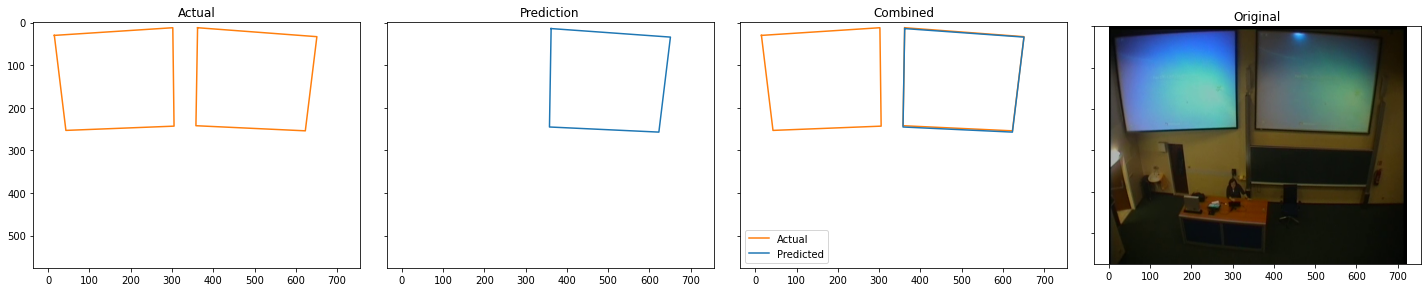

In [12]:
all_frames_visualization(frames_with_wrong_count, actual_detector, pred_detector_best)

In [13]:
frames_with_bad_ious = [all_frames[i] for i in really_bad_ious]

In [14]:
for frame in frames_with_bad_ious:
    pred_detector_best.detect(frame, seg_debug=True)

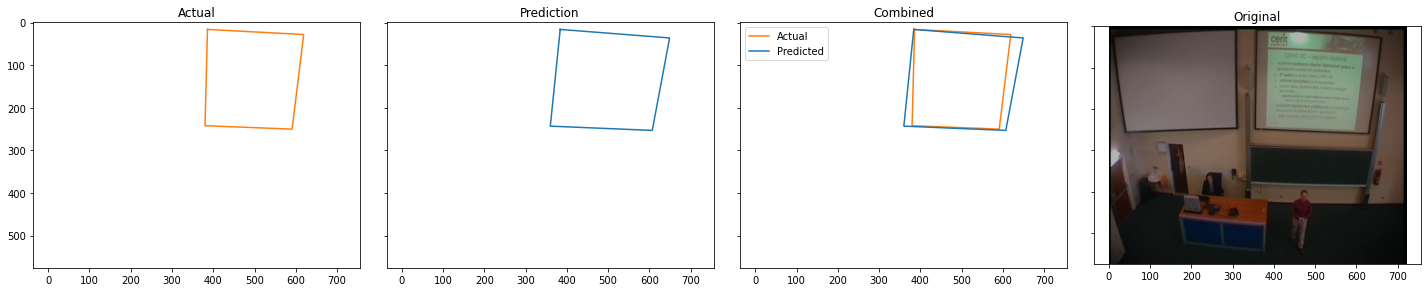

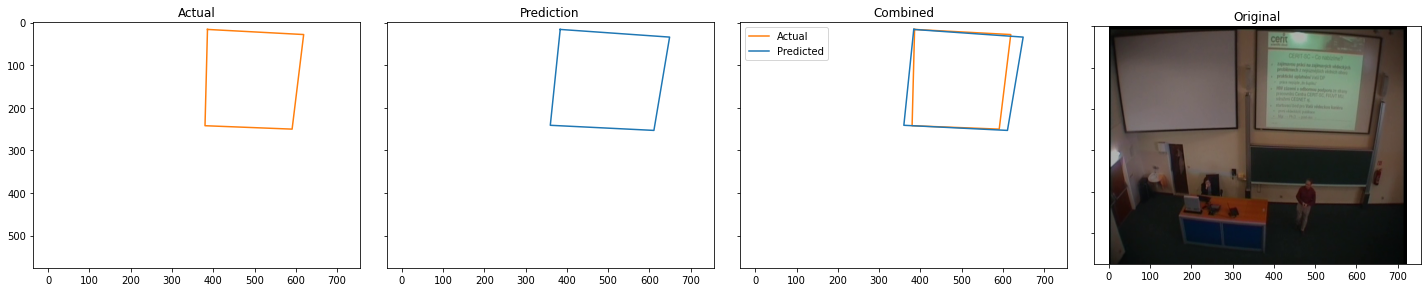

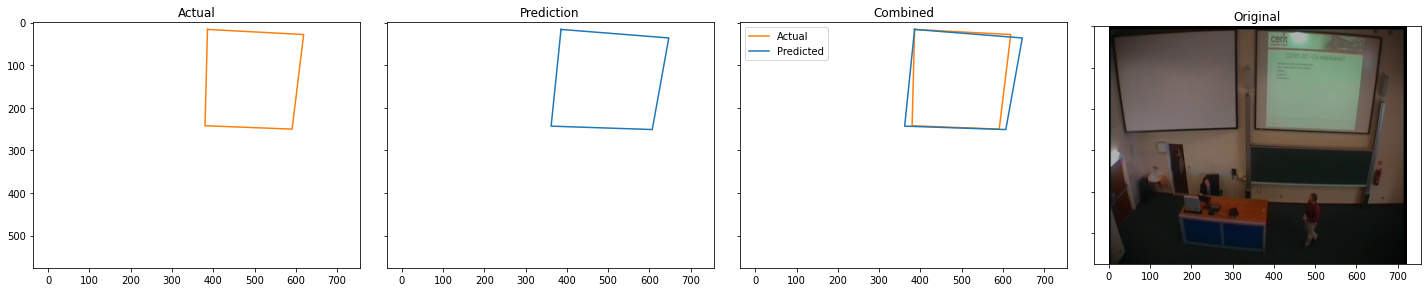

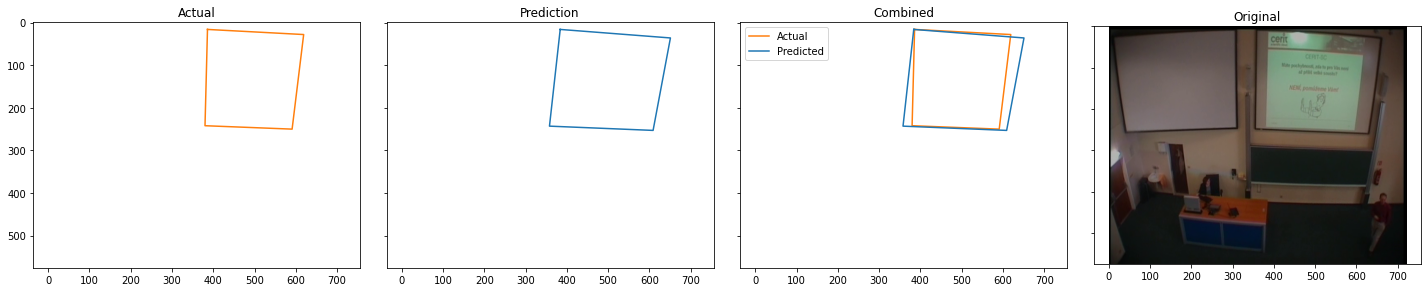

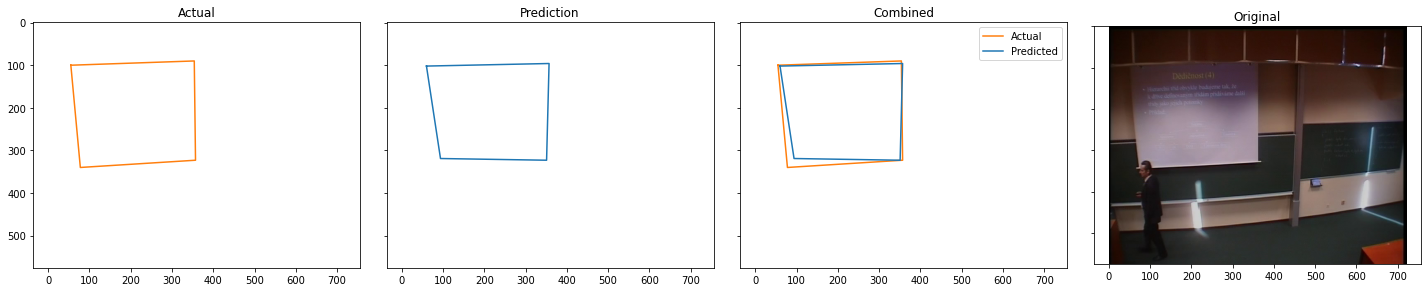

In [15]:
all_frames_visualization(frames_with_bad_ious, actual_detector, pred_detector_best)

## Get statistics about dataset

In [16]:
sizes, ratios = all_video_statistics(videos_list, actual_detector)

100%|██████████| 25/25 [00:00<00:00, 47858.33it/s]


In [17]:
def get_confidence_interval(data, ndigits=0):
    round_n_decimals = partial(round, ndigits=ndigits)
    data = np.array(data)
    mean, std = data.mean(), data.std()
    return map(round_n_decimals, scipy.stats.norm.interval(0.95, loc=mean, scale=std)) 

In [18]:
lower_area, upper_area = get_confidence_interval(sizes)
lower_area, upper_area

(36050.0, 99229.0)

In [19]:
lower_ratio, upper_ratio = get_confidence_interval(ratios, ndigits=3)
lower_ratio, upper_ratio

(0.648, 0.883)

## Grid Search for base postprocessing method

In [21]:
raw_preds = [pred_detector_best.detect(frame, seg_debug=True) for frame in tqdm(all_frames)]

In [22]:
assert len(raw_preds) == len(all_frames)

In [27]:
import itertools
from video699.screen.common import get_top_left_x
from video699.screen.fastai_detector import FastAIScreenDetectorVideoScreen

## All methods grid_search

In [44]:
lower_bounds = [20000]
upper_bounds = [200000]
factor_list = [[0.1, 0.01], [0.01,0.1]]
iterations = [40]
ratio_lower = [0.648]
ratio_upper = [1.5]

base = [lower_bounds, upper_bounds, factor_list]
base_columns = ['b_lower_bound', 'b_upper_bound', 'b_factors']

erode_dilate = [lower_bounds, upper_bounds, factor_list, iterations]
erode_dilate_columns = ['e_lower_bound', 'e_upper_bound', 'e_factors', 'e_iterations']

ratio_split = [ratio_lower, ratio_upper]
ratio_split_columns = ['r_lower_bound', 'r_upper_bound']

all_settings = list(itertools.product(*(base + erode_dilate + ratio_split)))

results = pd.DataFrame(columns=base_columns + erode_dilate_columns + ratio_split_columns + ['mean_iou', 'number_of_wrong_screens'])

In [45]:
len(all_settings)

4

In [46]:
for setting in tqdm(all_settings):
    base_params = {'lower_bound': setting[0], 'upper_bound': setting[1], 'factors': setting[2]}
    erode_dilate_params = {'lower_bound': setting[3], 'upper_bound': setting[4], 'factors': setting[5], 'iteration': setting[6]}
    ratio_split_params = {'lower_bound': setting[7], 'upper_bound': setting[8]}
    preds = []
    for raw_pred, frame in zip(raw_preds, all_frames):
        geos_quadrangles = approximate(raw_pred, methods={'base': base_params, 
                                                          'erode_dilate': erode_dilate_params,
                                                          'ratio_split': ratio_split_params})
        
        sorted_by_top_left_corner = sorted(geos_quadrangles, key=get_top_left_x)
        pred = [FastAIScreenDetectorVideoScreen(frame, screen_index, quadrangle) for screen_index, quadrangle in enumerate(sorted_by_top_left_corner)]
        preds.append(pred)
    
    wrong_count, ious, really_bad_ious = evaluate(actuals, preds)
    results.loc[len(results)] = [*setting, np.nanmean(ious), len(wrong_count)]

In [47]:
best_params = results[results['number_of_wrong_screens'] == results['number_of_wrong_screens'].min()].sort_values(by=['mean_iou'])

In [48]:
best_params

,b_lower_bound,b_upper_bound,b_factors,e_lower_bound,e_upper_bound,e_factors,e_iterations,r_lower_bound,r_upper_bound,mean_iou,number_of_wrong_screens
0,20000,200000,"[0.1, 0.01]",20000,200000,"[0.1, 0.01]",40,0.648,1.5,0.970205,1
1,20000,200000,"[0.1, 0.01]",20000,200000,"[0.01, 0.1]",40,0.648,1.5,0.970205,1
2,20000,200000,"[0.01, 0.1]",20000,200000,"[0.1, 0.01]",40,0.648,1.5,0.970205,1
3,20000,200000,"[0.01, 0.1]",20000,200000,"[0.01, 0.1]",40,0.648,1.5,0.970205,1


In [33]:
bad_frame = all_frames[wrong_count[0]]

In [35]:
raw_pred = pred_detector_best.detect(bad_frame, seg_debug=True)

In [36]:
base_params = {'lower_bound': 10000, 'upper_bound': 200000, 'factors': [0.9, 0.1,0.0001]}
# erode_dilate_params = {'lower_bound': 10000, 'upper_bound': 200000, 'factors': [0.9], 'iteration': 40}
# ratio_split_params = {'lower_bound': 0.648, 'upper_bound': 1.5}

screens = approximate(raw_pred, methods={
    'base': base_params, 
#     'erode_dilate': erode_dilate_params,
#     'ratio_split': ratio_split_params
}, debug=True)

len(screens)

1